In [13]:
%matplotlib


Using matplotlib backend: Qt5Agg


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sampleScatterGUI import SampleScatterGUI
import sklearn.manifold as skm
from latentImage import LatentImage
import sklearn.decomposition as skd
import numpy.random as rnd

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [4]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              15680     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 71,361
Trainable params: 71,361
Non-trainable params: 0
_______________________________________________________

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_labels = np.concatenate([y_train, y_test], axis=0)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=50, batch_size=256)


Epoch 1/50
274/274 [==============================] - 53s 188ms/step - loss: 289.1300 - reconstruction_loss: 221.4402 - kl_loss: 4.7398
Epoch 2/50
274/274 [==============================] - 52s 191ms/step - loss: 183.4418 - reconstruction_loss: 173.0139 - kl_loss: 6.3663
Epoch 3/50
274/274 [==============================] - 56s 203ms/step - loss: 164.1852 - reconstruction_loss: 152.1314 - kl_loss: 8.9645
Epoch 4/50
274/274 [==============================] - 54s 196ms/step - loss: 154.5461 - reconstruction_loss: 142.7230 - kl_loss: 9.8122
Epoch 5/50
274/274 [==============================] - 55s 199ms/step - loss: 145.9235 - reconstruction_loss: 133.8739 - kl_loss: 10.5751s - loss: 146.0222 - reconstruction_loss: 134.0326 -  - ETA: 1s - loss: 145.9780 - reconstruction_loss: 133.967
Epoch 6/50
274/274 [==============================] - 55s 200ms/step - loss: 141.8605 - reconstruction_loss: 130.4868 - kl_loss: 10.7302 44s - loss: 142.2545 - ETA: 34s - loss: 142.2630 - re - ETA: 26s - l - 

In [30]:
import latentInterpolationGUI as li
LI = li.LatentInterpolationGUI(vae.encoder, vae.decoder, mnist_digits)
indeces = rnd.randint(0,200,(3,))
LI.plotInterpolation(indeces, 10, 20)
plt.figure()
plt.subplot(2,3,1)
plt.imshow(mnist_digits[indeces[0]])
plt.subplot(2,3,2)
plt.imshow(mnist_digits[indeces[1]])
plt.subplot(2,3,3)
plt.imshow(mnist_digits[indeces[2]])

reconstruction = vae.decoder.predict( vae.encoder.predict(mnist_digits[indeces[0:1]])[0])[0]
plt.subplot(2,3,4)
plt.imshow(reconstruction)
reconstruction = vae.decoder.predict( vae.encoder.predict(mnist_digits[indeces[1:2]])[0])[0]
plt.subplot(2,3,5)
plt.imshow(reconstruction)
reconstruction = vae.decoder.predict( vae.encoder.predict(mnist_digits[indeces[2:3]])[0])[0]
plt.subplot(2,3,6)
plt.imshow(reconstruction)


[ 1.1323444   0.08978394  0.5333785  -0.44779134]
[ 1.0426337   0.15973306  0.57310086 -0.4285715 ]
[ 0.952923    0.22968219  0.61282325 -0.40935165]
[ 0.86321235  0.2996313   0.6525456  -0.3901318 ]
[ 0.77350163  0.36958045  0.69226795 -0.37091193]
[ 0.6837909   0.43952957  0.73199034 -0.35169208]
[ 0.59408027  0.5094787   0.77171266 -0.33247223]
[ 0.50436956  0.57942784  0.81143504 -0.3132524 ]
[ 0.41465884  0.649377    0.8511574  -0.2940325 ]
[ 0.32494813  0.719326    0.8908798  -0.2748127 ]
[ 0.23523748  0.78927517  0.9306022  -0.25559282]
[ 0.14552683  0.8592243   0.9703245  -0.23637299]
[ 0.05581617  0.92917335  1.0100468  -0.21715315]
[-0.03389454  0.9991226   1.0497693  -0.19793329]
[-0.12360525  1.0690717   1.0894916  -0.17871344]
[-0.21331596  1.1390208   1.129214   -0.15949357]
[-0.30302668  1.20897     1.1689364  -0.14027372]
[-0.39273727  1.278919    1.2086587  -0.1210539 ]
[-0.4824481   1.3488681   1.2483811  -0.10183403]
[-0.5721587   1.4188173   1.2881035  -0.08261418]


[ 0.98544204  1.0912641   0.2623866  -0.9834564 ]
[ 0.8957314  1.1612133  0.3021089 -0.9642365]
[ 0.8060207  1.2311624  0.3418313 -0.9450167]
[ 0.71630996  1.3011116   0.38155368 -0.9257968 ]
[ 0.62659925  1.3710606   0.42127606 -0.906577  ]
[ 0.5368886   1.4410098   0.46099845 -0.8873571 ]
[ 0.44717795  1.5109589   0.50072074 -0.8681373 ]
[ 0.3574673   1.580908    0.54044306 -0.8489174 ]
[ 0.26775658  1.6508572   0.5801655  -0.8296976 ]
[ 0.17804587  1.7208062   0.6198878  -0.81047773]
[ 0.08833516  1.7907554   0.6596103  -0.79125786]
[-1.3755560e-03  1.8607045e+00  6.9933259e-01 -7.7203798e-01]
[-0.09108615  1.9306536   0.7390549  -0.7528182 ]
[-0.18079698  2.0006027   0.77877736 -0.73359835]
[-0.27050757  2.0705519   0.8184997  -0.7143785 ]
[ 1.4717019   0.8229853   0.00507426 -1.1585262 ]
[ 1.3819911   0.89293444  0.04479665 -1.1393063 ]
[ 1.2922804   0.9628836   0.08451903 -1.1200864 ]
[ 1.2025698   1.0328326   0.12424135 -1.1008667 ]
[ 1.1128591   1.1027818   0.16396374 -1.081646

In [15]:
#vae.save('Model/variational_encoder_01.jns')

In [11]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


ValueError: in user code:

    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer decoder: expected shape=(None, 4), found shape=(None, 2)


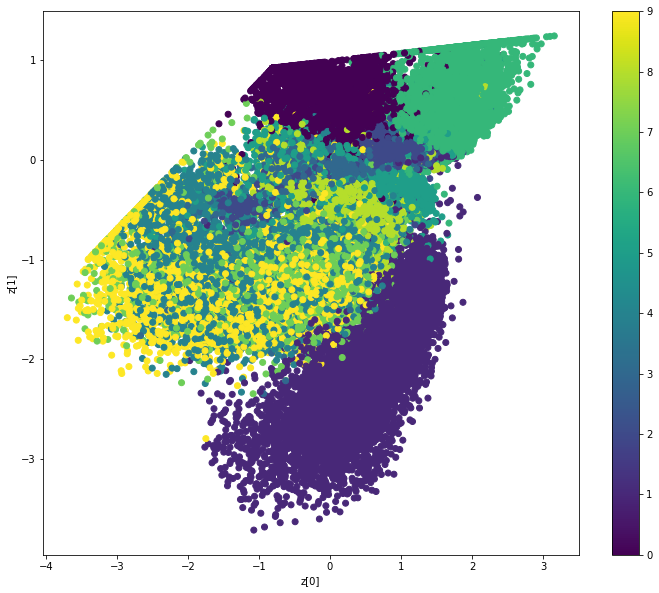

In [8]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)
indeces = rnd.randint(0,200,(3,))
LI.plotInterpolation(indeces, 10, 20)
plt.figure()
plt.subplot(2,3,1)
plt.imshow(mnist_digits[indeces[0]])
plt.subplot(2,3,2)
plt.imshow(mnist_digits[indeces[1]])
plt.subplot(2,3,3)
plt.imshow(mnist_digits[indeces[2]])

reconstruction = vae.decoder.predict( vae.encoder.predict(mnist_digits[indeces[0:1]])[0])[0]
plt.subplot(2,3,4)
plt.imshow(reconstruction)
reconstruction = vae.decoder.predict( vae.encoder.predict(mnist_digits[indeces[1:2]])[0])[0]
plt.subplot(2,3,5)
plt.imshow(reconstruction)
reconstruction = vae.decoder.predict( vae.encoder.predict(mnist_digits[indeces[2:3]])[0])[0]
plt.subplot(2,3,6)
plt.imshow(reconstruction)

In [16]:
z_mean, z_var, z_val = vae.encoder.predict(mnist_digits)

In [17]:
z_tsne = skm.TSNE().fit_transform(z_mean)

In [28]:
digit = 4
pca = skd.PCA(n_components = 2)
pca.fit(z_mean[mnist_labels[mnist_labels==digit]])
z_vectors = (pca.components_.T *3*np.sqrt(pca.explained_variance_)).T
LI = LatentImage(vae.decoder, plt.figure(), latent_vectors = z_vectors, original_point = np.mean(z_mean[mnist_labels==digit]) )


C:\Users\joelw\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:554: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()


ValueError: in user code:

    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\joelw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_1 is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape (None, 1)


In [29]:
SG = SampleScatterGUI(z_tsne, mnist_labels, mnist_digits)

In [8]:
import latentInterpolationGUI as li
LI = li.LatentInterpolationGUI(vae.encoder, vae.decoder, mnist_digits)

In [20]:
indeces = rnd.randint(0,200,(3,))
LI.plotInterpolation(indeces, 10, 20)
plt.figure()
plt.subplot(2,3,1)
plt.imshow(mnist_digits[indeces[0]])
plt.subplot(2,3,2)
plt.imshow(mnist_digits[indeces[1]])
plt.subplot(2,3,3)
plt.imshow(mnist_digits[indeces[2]])

reconstruction = vae.decoder.predict( vae.encoder.predict(mnist_digits[indeces[0:1]])[0])[0]
plt.subplot(2,3,4)
plt.imshow(reconstruction)
reconstruction = vae.decoder.predict( vae.encoder.predict(mnist_digits[indeces[1:2]])[0])[0]
plt.subplot(2,3,5)
plt.imshow(reconstruction)
reconstruction = vae.decoder.predict( vae.encoder.predict(mnist_digits[indeces[2:3]])[0])[0]
plt.subplot(2,3,6)
plt.imshow(reconstruction)

[ 0.20064127  0.13982457 -1.1066232   0.01004616]
[ 0.21220028  0.19525667 -0.94942856  0.00982883]
[ 0.22375931  0.25068876 -0.792234    0.0096115 ]
[ 0.23531832  0.30612084 -0.63503945  0.00939417]
[ 0.24687734  0.36155295 -0.47784483  0.00917684]
[ 0.25843635  0.41698503 -0.32065022  0.00895951]
[ 0.26999536  0.47241712 -0.16345567  0.00874218]
[ 0.2815544   0.5278492  -0.00626111  0.00852485]
[0.2931134  0.5832813  0.1509335  0.00830752]
[0.30467242 0.6387134  0.30812812 0.00809019]
[0.31623143 0.6941455  0.46532273 0.00787286]
[0.32779044 0.7495776  0.62251735 0.00765553]
[0.33934945 0.80500966 0.77971184 0.0074382 ]
[0.3509085  0.8604418  0.9369066  0.00722087]
[0.3624675  0.9158739  1.094101   0.00700354]
[0.37402654 0.971306   1.2512958  0.00678621]
[0.38558555 1.026738   1.4084902  0.00656888]
[0.39714456 1.0821701  1.5656848  0.00635155]
[0.40870357 1.1376023  1.7228794  0.00613421]
[0.42026258 1.1930344  1.880074   0.00591688]
[ 0.21043923  0.10034543 -1.0322841   0.00975344

In [ ]:
vae.save('Model/variational_encoder_01')

In [11]:
indeces = [0,10,30]
LI.plotInterpolation(indeces, 2, 3)

[-1.8809012   0.34225452  0.67140734  1.2386935 ]
[-1.5083852   0.5401276   0.61206555  0.79484606]
[-1.135869    0.73800063  0.55272377  0.3509987 ]
[-2.0443563  -0.43602276  0.5132394   1.9243664 ]
[-1.6718403 -0.2381497  0.4538976  1.4805189]
[-1.2993242  -0.04027665  0.3945558   1.0366716 ]


In [23]:
reconstruction = vae.encoder.predict(mnist_digits[1:2])


In [36]:
num_row = 3
num_col = 4
im_height, im_width, im_channels = mnist_digits[0].shape

In [38]:
I = np.zeros((num_row, num_col, im_height, im_width, im_channels))

In [64]:
ind = i = rnd.randint(0,10, (num_row,num_col))
plt.figure()

for row in range(num_row):
    for col in range(num_col):
        i = ind[row,col]
        plt.subplot(num_row,num_col, col+num_col*row+1)
        plt.imshow(mnist_digits[i])
        I[row,col,:,:,:] = mnist_digits[i]
        
plt.figure()
J = I.swapaxes(1,2).reshape((num_row*im_height,num_col*im_width, im_channels))
plt.imshow(J)

(84, 112, 1)

In [21]:
vae.save('Model/variational_encoder_01')

ValueError: Model <__main__.VAE object at 0x000002629A347B20> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined from calling `.fit()` or `.predict()`. To manually set the shapes, call `model.build(input_shape)`.